In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize



def my_loss_fn(ytruetest, ytruetrain, ypredtest, ypredtrain):
    loss = np.array([[0,1,2],[1,0,1],[2,1,0]])
    days = len(ytruetest)
    losstrain = np.zeros(days)
    losstest = np.zeros(days)
    acctrain = np.zeros(days)
    acctest = np.zeros(days)
    acctrain1 = np.zeros(days)
    acctest1 = np.zeros(days)
    
    for i in range(days):
        conftrain = confusion_matrix(ytruetrain[i], ypredtrain[i])
        acctrain[i] = (conftrain[0,0] + conftrain[2,2])/np.sum(conftrain[0] + conftrain[2])
        acctrain1[i] = (conftrain[0,0] + conftrain[2,2])/np.sum(
            conftrain[0,0] + conftrain[0,2] + conftrain[2,0] + conftrain[2,2])
        losstrain[i] = np.sum(conftrain * loss)
        
        conftest = confusion_matrix(ytruetest[i], ypredtest[i])
        acctest[i] = ((conftest[0,0] + conftest[2,2])/
                      np.sum(conftest[0] + conftest[2]))
        acctest1[i] = (conftest[0,0] + conftest[2,2])/np.sum(
            conftest[0,0] + conftest[0,2] + conftest[2,0] + conftest[2,2])
        losstest[i] = np.sum(conftest * loss)
    
    ind = [('Day ' + str(i+1))for i in range(days)]
    col = ['Loss Train','Loss Test','Accuracy Train 1',
           'Accuracy Train 2','Accuracy Test 1',
           'Accuracy Test 2']
    retv = zip(col,(losstrain, losstest, acctrain, acctrain1, acctest, acctest1))
    return pd.DataFrame(dict(retv),index=ind)

# Loading in Data

In [2]:
DF = pd.read_csv('ESH2019_final.csv',
                 index_col = 0,
                 dtype={'Time':str})

D:\Programs\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
DF.head()

,Date,msecs,Time,Bid Price,Bid Size,Ask Price,Ask Size,Mid,dM,M_10ma,...,OI,OI_a1,OI_a2,OI_a3,OI_a4,OI_a5,OI_5ma,OI_10ma,OI_20ma,OI Ratio
0,01/02/2019,28800000.0,07:59:59.757,2467.50,9.0,2467.75,36.0,2467.625,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.600000
1,01/02/2019,28800500.0,08:00:00.305,2467.25,36.0,2467.50,19.0,2467.375,-0.25,NaN,...,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309091
2,01/02/2019,28801000.0,08:00:00.826,2467.25,42.0,2467.50,3.0,2467.375,0.00,NaN,...,22.0,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667
3,01/02/2019,28801500.0,08:00:01.349,2467.25,29.0,2467.50,30.0,2467.375,0.00,NaN,...,-40.0,22.0,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.016949
4,01/02/2019,28802000.0,08:00:01.761,2467.25,42.0,2467.50,22.0,2467.375,0.00,NaN,...,21.0,-40.0,22.0,-19.0,NaN,NaN,NaN,NaN,NaN,0.312500


In [4]:
DF.loc[:,'Time'] = DF.loc[:,'Time'].replace(np.nan,'',regex=True)

# Exploration

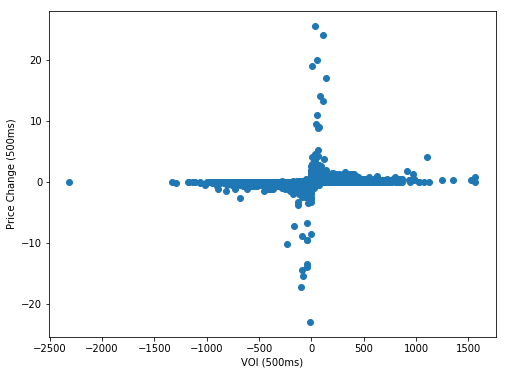

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(DF['OI'],DF['dM'])
plt.xlabel("VOI (500ms)")
plt.ylabel("Price Change (500ms)")
plt.show()

In [6]:
DF[['OI','dM']].corr()

,OI,dM
OI,1.000000,0.361549
dM,0.361549,1.000000


# SVM

In [7]:
# defining which features to use

x_labs = ['OI_a1', 'OI_a2', 'OI_a3', 'OI_a4', 'OI_a5',
          'OI Ratio','OI_10ma','OI_20ma'] # covars
y_labs = ['signal6']

In [8]:
def my_confusion_matrix(ytrue,ypred,labs=[1,0,-1]):
    from sklearn.metrics import confusion_matrix
    cols = ['Buy (p)','Hold (p)','Sell (p)']
    ind = ['Buy (t)','Hold (t)','Sell (t)']
    mat = confusion_matrix(ytrue,ypred,labs)
    return pd.DataFrame(mat, columns=cols,index=ind)

## Cross Validation

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# trading loss for our own CV
def trading_loss(ytrue,ypred):
    conftrain = confusion_matrix(ytrue, ypred)
    loss = np.array([[0,1,2],[1,0,1],[2,1,0]])
    return np.sum(conftrain * loss)

# callable to score for CV
trade_scorer=make_scorer(trading_loss,greater_is_better=False)

### Extracting the train/test indexes

In [10]:
def my_train_test_idx(DF,xlabs=x_labs,ylabs=['signal6'],return_df=False,n_days=4):
    '''
    input your data frame and which x's you want to use
        as a list into xlabs
        
    return_df to return new data frame for CV
    return value is list of 2-tuples of train & test
        index iterables
        - pass directly into the cv parameter of cross_validate
    '''
    df = DF[['Date']+xlabs+ylabs].dropna()
    
    #list of lengths of each day's data
    lengths = []
    for d in np.unique(DF['Date'].values)[:n_days]:
        lengths.append(df[df['Date']==d].shape[0])
    
    # where each day starts/ends
    bounds = np.cumsum(lengths)
    
    # list of 2-tuples of train & test indexes
    train_test_idx=[]
    prev=0
    for idx,val in enumerate(bounds[:-1]):
        train_id = range(prev,val)
        test_id = range(val,bounds[idx+1])
        prev = val
        train_test_idx.append((train_id,test_id))
    
    if return_df:
        return (train_test_idx,df)
    return (train_test_idx)

In [11]:
idxs, df_cv = my_train_test_idx(DF,x_labs,return_df=True)
idxs

[(range(0, 50381), range(50381, 100763)),
 (range(50381, 100763), range(100763, 151145)),
 (range(100763, 151145), range(151145, 201527))]

## Testing CV and GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV
tune_params = {'C':np.logspace(-5,5,20)}

In [14]:
fit = GridSearchCV(svm.LinearSVC(dual=False,class_weight='balanced'),
                   tune_params,scoring=trade_scorer,cv=idxs)
fit.fit(df_cv[x_labs].values,y=df_cv['signal6'].values)

GridSearchCV(cv=[(range(0, 50381), range(50381, 100763)), (range(50381, 100763), range(100763, 151145)), (range(100763, 151145), range(151145, 201527))],
       error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 3.35982e-05, 1.12884e-04, 3.79269e-04, 1.27427e-03,
       4.28133e-03, 1.43845e-02, 4.83293e-02, 1.62378e-01, 5.45559e-01,
       1.83298e+00, 6.15848e+00, 2.06914e+01, 6.95193e+01, 2.33572e+02,
       7.84760e+02, 2.63665e+03, 8.85867e+03, 2.97635e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(trading_loss, greater_is_better=False),
       verbose=0)

In [15]:
best_C = fit.best_params_['C']
fit.best_params_

{'C': 1.8329807108324339}

In [16]:
temp = df_cv[df_cv['Date']=='01/03/2019']
sv = svm.LinearSVC(C=fit.best_params_['C'],dual=False,class_weight='balanced')
sv.fit(temp[x_labs],temp['signal6'])
pred = sv.predict(temp[x_labs])
my_confusion_matrix(temp['signal6'],pred,[1,0,-1])

,Buy (p),Hold (p),Sell (p)
Buy (t),11308,1052,3324
Hold (t),7762,1820,8036
Sell (t),3370,1114,12596


In [75]:
# figure out how to do feature importance for SVM?
'''
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances(sv.coef_, x_labs)
'''

"\ndef f_importances(coef, names):\n    imp = coef\n    imp,names = zip(*sorted(zip(imp,names)))\n    plt.barh(range(len(names)), imp, align='center')\n    plt.yticks(range(len(names)), names)\n    plt.show()\nf_importances(sv.coef_, x_labs)\n"

## Testing on Data Set

In [17]:
train_CFM  = []    # training confusion matrices
test_CFM   = []    # test confusion matrices

train_loss = []    # training loss
test_loss  = []    # test loss

y_pred_vec_tr = [] # training predictions
y_true_vec_tr = [] # true training values

y_pred_vec_te = [] # test predictions
y_true_vec_te = [] # true test predictions


i_vec = my_train_test_idx(DF,x_labs,['signal6'],
                 return_df=False,
                 n_days=np.unique(DF['Date']).shape[0]
                )
test_idx = i_vec[3:]
df_test = df_cv.copy()

In [ ]:
###### TESTING ON THE DATA ######
sv_fit = svm.LinearSVC(C=best_C,dual=False,class_weight='balanced')
for i,j in tqdm(test_idx):
    X_train = df_test.iloc[i,:][x_labs].values
    y_train = df_test.iloc[i,:]['signal6'].values
    X_test = df_test.iloc[j,:][x_labs].values
    y_test = df_test.iloc[j,:]['signal6'].values
    
    sv_fit.fit(X_train,y_train)
    
    # predictions
    p_tr = sv_fit.predict(X_train)
    p_te = sv_fit.predict(X_test)
    
    y_pred_vec_tr.append(p_tr)
    y_pred_vec_te.append(p_te)
    
    y_true_vec_tr.append(y_train)
    y_true_vec_te.append(y_test)
    
    # confusion matrices
    train_CFM.append(my_confusion_matrix(y_train,p_tr,[1,0,-1]))
    test_CFM.append(my_confusion_matrix(y_test,p_te,[1,0,-1]))
    
    # loss
    train_loss.append(trading_loss(y_train,p_tr))
    test_loss.append(trading_loss(y_test,p_te))